# Proyecto 1 - Inteligencia de Negocios

1. Integrantes de Ingeniería de sistemas y computación:
- Sebastián Alberto Umaña Peinado
- Santiago Rodriguez Cruz
2. Integrantes de Estadística:
- Karol Biviana clavijo criollo
- Julio Alberto Gutierrez De Armas

#### Objetivos
Aislar las características que asocian a un sitio a una opinión positiva o negativa para que el ministerio de turismo y las cadenas hoteleras definan qué características son pertinentes para que las personas perciben hacia un lugar y crear estrategias de mejora para impulsar el turismo en estos lugares

#### Criterios de Aceptación
- Predecir si una reseña es positiva o negativa 
- Extraer características que definan si una reseña es positiva o negativa 

#### RoadMap 
Ya que los actores interesados en el proyecto requieren extraer, procesar y utilizar las percepciones de un sitio según sus reseñas, que pueden ser positiva o negativa para crear estrategias que fomenten esta industria se usará la técnica de aprendizaje supervisado de clasificación. Se Hará un entendimiento inicial de la estructura general de los datos, Se procesarán las reseñas por medio de técnicas de lenguaje natural y limpieza general de datos y posteriormente se convertirá en un formato entendible por el modelo para crear resultados pertinentes e ilustradores. 

#### Metodología
Dado que el contexto y corpus de las reseñas es estable, se probará el entrenamiento del modelo vectorizando las reseñas con TF-IDF .Elegimos TF-IDF dado que permite resaltar  las palabras de mayor importancia  en todo el corpus del texto ,filtrando las que estén presentes en todos los textos  dado que no aportan información útil sin  ignorar las que son relevantes en cada documento.

Se valorarán los siguientes 3 algoritmos y se harán pruebas para elegir el mejor según lo que necesite la empresa. 

- Logistic Regression   

- Random Forest 

- SVM 

Se eligieron estos algoritmos dado su uso frecuente en tareas similares de análisis de texto y que manejan bien grafos/matrices dispersas, que son las que arroja el TF-IDF.





# Librerías

In [130]:
#librerias para un proyecto de análitica de texto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflect
import unicodedata
import re   
from sklearn.model_selection import train_test_split
from langdetect import detect
from sklearn.metrics import classification_report,f1_score, precision_score, recall_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline




In [131]:
#instalar los paquetes de nltk para identificar las palabras y tokenizarlas.
#nltk.download()

# 1-Entendimiento de los datos

In [132]:
df_o = pd.read_csv('tipo1_entrenamiento_estudiantes.csv', encoding='utf-8')
df = df_o.copy(deep=True)
df.head(5)

df_particion = pd.read_csv('particion.csv', encoding='utf-8') #particion de datos para evaluar el modelo, debemos aplicar el mismo preprocesamiento


In [133]:
#mirar si hay valores nulos
df.isnull().sum()

Review    0
Class     0
dtype: int64

In [134]:
#mirar duplicados
df.duplicated().sum()

71

In [135]:
#identificar los idiomas de los textos
df['idioma'] = df['Review'].apply(detect)
df_particion['idioma'] = df_particion['Review'].apply(detect)
df.head(5)

,Review,Class,idioma
0,Nos alojamos en una casa alquilada en la ciuda...,4,es
1,"La comida está bien, pero nada especial. Yo te...",3,es
2,"En mi opinión, no es una como muchos usuarios ...",3,es
3,esta curiosa forma que asemeja una silla de mo...,4,es
4,Lo mejor era la limonada. Me gusto la comida d...,2,es


In [136]:
df.describe()

,Class
count,7875.000000
mean,3.491683
std,1.328275
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


<Axes: xlabel='Class', ylabel='count'>

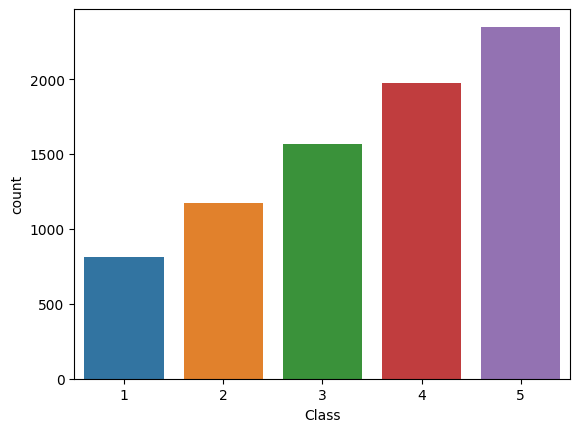

In [137]:
sns.countplot(x = "Class", data = df)

In [138]:
#distribución y proporcion de los idiomas
idiomas = df['idioma'].value_counts(normalize=True)
idiomas

idioma
es    0.999365
en    0.000635
Name: proportion, dtype: float64

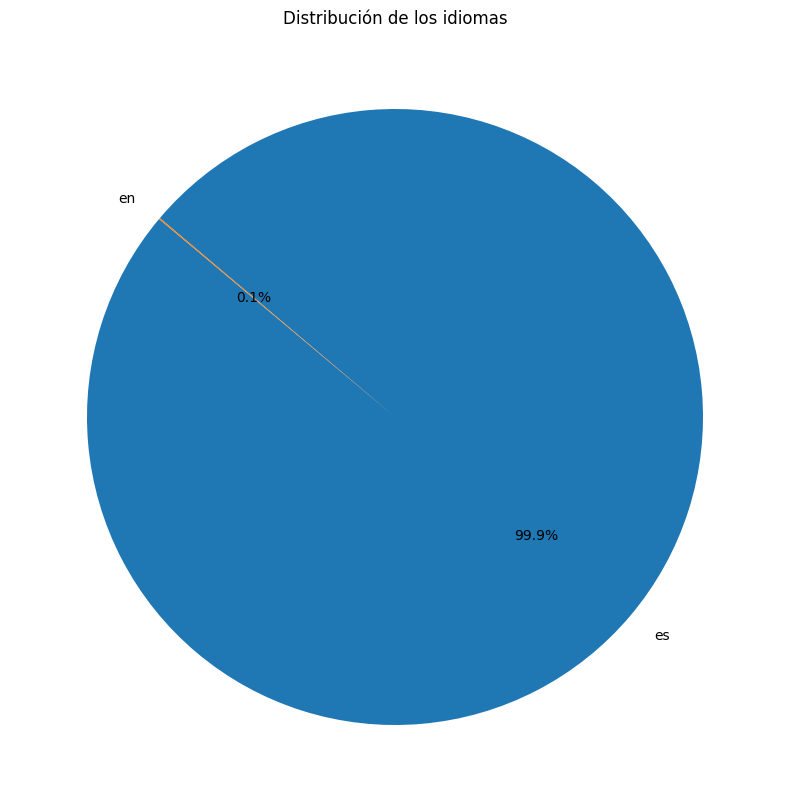

In [139]:
#distribución y proporcion de los idiomas
idiomas = df['idioma'].value_counts(normalize=True)

#graficar la distribución de los idiomas en grafica de torta
plt.figure(figsize=(10,10))
plt.pie(idiomas, labels = idiomas.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de los idiomas')
plt.show()


In [140]:
#ver cuantos registros hay por idioma
df['idioma'].value_counts()

idioma
es    7870
en       5
Name: count, dtype: int64

# 2-Limpieza de datos

In [141]:
df = df.explode('Review') #separar las palabras de las frases 
df.reset_index(drop=True, inplace=True) #reiniciamos el indice del dataframe

df_particion = df_particion.explode('Review') 
df_particion.reset_index(drop=True, inplace=True) 


In [142]:
#borramos nulos
df = df.dropna()
df_particion = df_particion.dropna()

In [143]:
#borramos duplicados
df = df.drop_duplicates()
df_particion = df_particion.drop_duplicates()

In [144]:
df.head(5)

,Review,Class,idioma
0,Nos alojamos en una casa alquilada en la ciuda...,4,es
1,"La comida está bien, pero nada especial. Yo te...",3,es
2,"En mi opinión, no es una como muchos usuarios ...",3,es
3,esta curiosa forma que asemeja una silla de mo...,4,es
4,Lo mejor era la limonada. Me gusto la comida d...,2,es


In [145]:
#borramos los registros que no esten en español
df = df[df['idioma'] == 'es']
df_particion = df_particion[df_particion['idioma'] == 'es']

 En el proceso de clasificación  hemos definido una serie de pasos para preprocesar nuestros datos de manera efectiva y que la clasificación sea correcta. Comenzamos eliminando caracteres especiales y convirtiendo todo el texto a minúsculas, lo que nos permite homogeneizar el formato y facilitar el análisis. Luego, eliminamos la puntuación para simplificar el contenido aún más. Posteriormente, hemos optado por sustituir los números por su forma textual equivalente, lo que contribuye a mantener el significado semántico de la reseña. Luego, procedemos a tokenizar las palabras, dividiendo el texto en unidades significativas, lo que nos permite trabajar a un nivel más granular facilitando el uso de un Stemmer. Finalmente, hemos implementado la eliminación de las palabras vacías de significado (StopWords), que son términos comunes que generalmente no aportan ningún valor semántico al análisis. Este enfoque integral de preprocesamiento nos permite preparar nuestros datos de manera óptima para la clasificación, mejorando la eficacia y la precisión de nuestro modelo.

In [146]:
#removemos los caracteres especiales
def limpiar_ascii(text):
    new_words = []
    for word in text:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [147]:
#Convertimos a minusculas
def limpiar_minusculas(text):
    new_words = []
    for word in text:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [148]:
#removemos puntuacion utilizando expresiones regulares
def limpiar_puntuacion(text):
    new_words = []
    for word in text:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [149]:
#cambiamos los numeros a texto. 5 -> cinco
p = inflect.engine()
def limpiar_numeros(text):
    new_words = []
    for word in text:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [150]:
#quitamos las stopwords como los articulos, preposiciones, etc...
#quitar stopwords
def remove_stopwords(text):
    new_words = []
    for word in text:
        if word not in STOP_WORDS: #STOP_WORDS es un conjunto de palabras en español tomadas de spacy
            new_words.append(word)
    return new_words

In [151]:
#aplicamos las funciones de limpieza
def procesar_texto(text):
    text = limpiar_ascii(text)
    text = limpiar_minusculas(text)
    text = limpiar_puntuacion(text)
    text = limpiar_numeros(text)
    return text

df['Clean_Review'] = df['Review'].apply(word_tokenize).apply(procesar_texto).apply(remove_stopwords)
df_particion['Clean_Review'] = df_particion['Review'].apply(word_tokenize).apply(procesar_texto).apply(remove_stopwords)
df.head(5)

,Review,Class,idioma,Clean_Review
0,Nos alojamos en una casa alquilada en la ciuda...,4,es,"[alojamos, casa, alquilada, ciudad, amurallada..."
1,"La comida está bien, pero nada especial. Yo te...",3,es,"[comida, especial, tenia, comida, mexcan, unid..."
2,"En mi opinión, no es una como muchos usuarios ...",3,es,"[opinion, usuarios, reclaman, paladar, parada,..."
3,esta curiosa forma que asemeja una silla de mo...,4,es,"[curiosa, forma, asemeja, silla, montar, nombr..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,es,"[limonada, gusto, comida, mundo, sosa, frio]"


Hemos decidido optar por la integración de un Stemmer para nuestro proceso de análisis de texto, específicamente hemos implementado el SnowballStemmer de la librería NLTK. Esta elección estratégica está fundamentada en la necesidad de reducir la complejidad léxica del corpus, llevando las palabras a su raíz. Al hacer esto, no solo reducimos la cantidad de términos que deben ser analizados, sino que también minimizamos el costo computacional asociado con el procesamiento de texto. Esta acción no solo contribuye a una mayor eficiencia en el tratamiento de datos, sino que también puede potencialmente mejorar la precisión del modelo. Al unificar términos que comparten raíz que pueden tener significados iguales o similares, no solo reducimos la redundancia léxica, sino que también aumentamos la capacidad del modelo para capturar la esencia semántica del texto, lo que a su vez fortalece su capacidad predictiva y su capacidad para encontrar patrones.

In [152]:
ps = SnowballStemmer('spanish')

def porter_stemmer_spanish(text):
    return [ps.stem(word) for word in text]

def join_words(words):
    return ' '.join(words)

def process_data(text):
    return text.apply(porter_stemmer_spanish).apply(join_words)

data_split = np.array_split(df['Clean_Review'], 4)
df['Clean_Review'] = pd.concat(Parallel(n_jobs=4)(delayed(process_data)(text) for text in data_split))



C:\Users\sebas\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [153]:
#stemming para la particion
data_split2 = np.array_split(df_particion['Clean_Review'], 4)
df_particion['Clean_Review'] = pd.concat(Parallel(n_jobs=4)(delayed(process_data)(text) for text in data_split2))

C:\Users\sebas\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Polarizamos los datos en 3 secciones para que ayudar al modelo de clasificación de forma que simplificamos y clasificamos la columna Class

In [154]:
#clasificacion de las reseñas en mala, neutral y buena
df['Rating'] = None
for index, rows in df.iterrows():
    if(rows['Class'] >= 1 and rows['Class'] < 3):
        df.at[index, 'Rating'] = 1 #mala
    elif(rows['Class'] == 3):
        df.at[index,'Rating'] = 2 #neutral
    elif(rows['Class'] > 3 and rows['Class'] <= 5 ):
        df.at[index,'Rating'] = 3 #buena
df

,Review,Class,idioma,Clean_Review,Rating
0,Nos alojamos en una casa alquilada en la ciuda...,4,es,aloj cas alquil ciud amurall pareci segur ciud...,3
1,"La comida está bien, pero nada especial. Yo te...",3,es,com especial teni com mexc unid margarit genia...,2
2,"En mi opinión, no es una como muchos usuarios ...",3,es,opinion usuari reclam palad par grup excursion...,2
3,esta curiosa forma que asemeja una silla de mo...,4,es,curios form asemej sill mont nombr icon ciud v...,3
4,Lo mejor era la limonada. Me gusto la comida d...,2,es,limon gust com mund sos fri,1
...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,es,motiv estanci vin congres medic hosped lug ins...,2
7871,Es difícil revisar el castillo porque apenas p...,3,es,dificil revis castill podi camin sofoc calor p...,2
7872,Si vas a Mérida no puedes perderte de este lug...,5,es,vas mer pued perdert lug sucursal ampli calid ...,3
7873,"Este imperdible sitio, que lleva el nombre del...",5,es,imperd siti nombr conquist joy urbanasu amplit...,3


<Axes: xlabel='Rating', ylabel='count'>

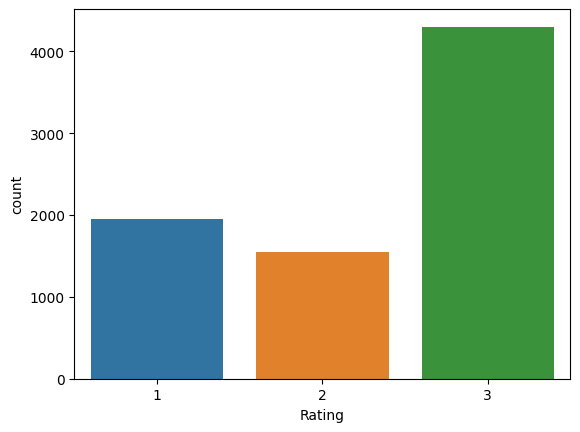

In [155]:
sns.countplot(x = "Rating", data = df)

# 3-Modelos

para este proyecto utilizaremos los siguientes 3 algoritmos:

#### Regresión Logistica:
 En el proceso de clasificación  hemos definido una serie de pasos para preprocesar nuestros datos de manera efectiva y que la clasificación sea correcta. Comenzamos eliminando caracteres especiales y convirtiendo todo el texto a minúsculas, lo que nos permite homogeneizar el formato y facilitar el análisis. Luego, eliminamos la puntuación para simplificar el contenido aún más. Posteriormente, hemos optado por sustituir los números por su forma textual equivalente, lo que contribuye a mantener el significado semántico de la reseña. Luego, procedemos a tokenizar las palabras, dividiendo el texto en unidades significativas, lo que nos permite trabajar a un nivel más granular facilitando el uso de un Stemmer. Finalmente, hemos implementado la eliminación de las palabras vacías de significado (StopWords), que son términos comunes que generalmente no aportan ningún valor semántico al análisis. Este enfoque integral de preprocesamiento nos permite preparar nuestros datos de manera óptima para la clasificación, mejorando la eficacia y la precisión de nuestro modelo. 	
##### Random Forest:
Support Vector Machine (SVM) es un algoritmo de aprendizaje automático supervisado que se utiliza para tareas de clasificación y regresión. En el contexto de la clasificación, SVM tiene como objetivo encontrar el hiperplano óptimo que separe las instancias de diferentes clases en el espacio de características.Lo elegimos por que además de ser similar a Logistic Regression , es robusto a overfitting y se adapta a datos dispersos, también se adapta bien a muchas dimensiones, que para esta tarea corresponde al vocabulario del corpus donde cada palabra es una dimensión.
 	
##### Support Vector Machine(SVM):
Support Vector Machine (SVM) es un algoritmo de aprendizaje automático supervisado que se utiliza para tareas de clasificación y regresión. En el contexto de la clasificación, SVM tiene como objetivo encontrar el hiperplano óptimo que separe las instancias de diferentes clases en el espacio de características.Lo elegimos por que además de ser similar a Logistic Regression , es robusto a overfitting y se adapta a datos dispersos, también se adapta bien a muchas dimensiones, que para esta tarea corresponde al vocabulario del corpus donde cada palabra es una dimensión.

#### selección de variable objetivo y datos de entrenamiento

In [156]:
df["Rating"] = df["Rating"].astype(int)
y = df.Class #variable objetivo

X_train1,X_test1,y_train1,y_test1 = train_test_split(df["Clean_Review"],y,test_size=0.20,random_state=123,stratify=y)


### Logistic Regresion

In [157]:
pipeline = Pipeline(steps = [('tfidf',TfidfVectorizer()),
                             ('lr',LogisticRegression(random_state=42, multi_class='multinomial',solver='newton-cg'))])

pipeline.fit(df["Clean_Review"], y)

y_pred = pipeline.predict(df["Clean_Review"])


print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           1       0.87      0.68      0.76       787
           2       0.79      0.71      0.75      1160
           3       0.77      0.69      0.73      1552
           4       0.74      0.74      0.74      1962
           5       0.76      0.90      0.83      2338

    accuracy                           0.77      7799
   macro avg       0.79      0.75      0.76      7799
weighted avg       0.77      0.77      0.77      7799



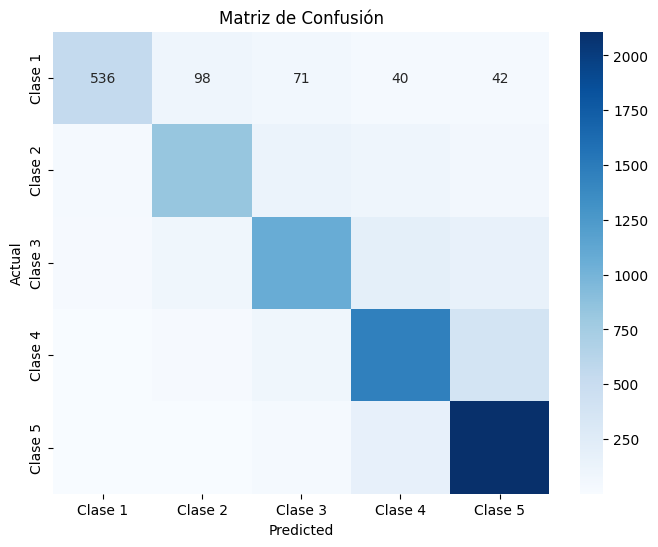

In [158]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4','Clase 5'], yticklabels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4','Clase 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### Random Forest

In [159]:
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfclf', RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50,random_state = 42))
])


rf_pipeline.fit(df["Clean_Review"], y)


rfpred=rf_pipeline.predict(df["Clean_Review"])



print("Random Forest")
print(classification_report(y,rfpred))


Random Forest
              precision    recall  f1-score   support

           1       1.00      0.89      0.94       787
           2       1.00      0.89      0.94      1160
           3       1.00      0.89      0.94      1552
           4       0.98      0.95      0.96      1962
           5       0.84      1.00      0.91      2338

    accuracy                           0.94      7799
   macro avg       0.96      0.92      0.94      7799
weighted avg       0.95      0.94      0.94      7799



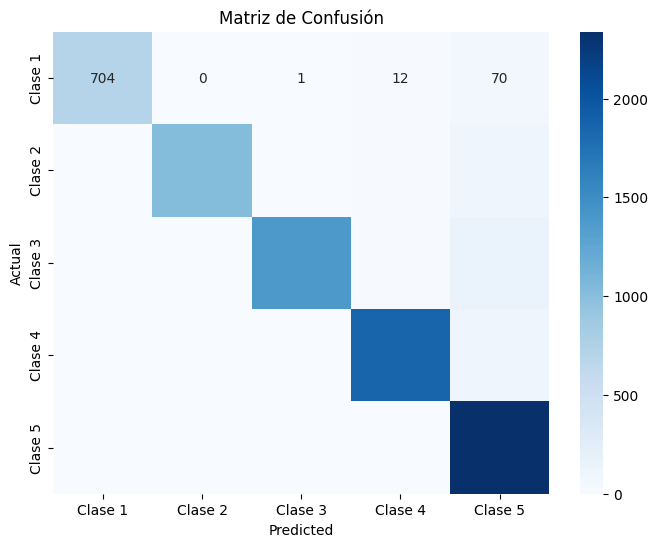

In [160]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, rfpred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4','Clase 5'], yticklabels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4','Clase 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### Support Vector Machine (SVM)

In [161]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svmclf', SVC(kernel='rbf'))
])

svm_pipeline.fit(df["Clean_Review"], y)
svmpred=svm_pipeline.predict(df["Clean_Review"])

print("SVM")
print(classification_report(y,svmpred))

SVM
              precision    recall  f1-score   support

           1       1.00      0.95      0.97       787
           2       0.98      0.96      0.97      1160
           3       0.98      0.96      0.97      1552
           4       0.96      0.96      0.96      1962
           5       0.95      0.99      0.97      2338

    accuracy                           0.97      7799
   macro avg       0.97      0.96      0.97      7799
weighted avg       0.97      0.97      0.97      7799



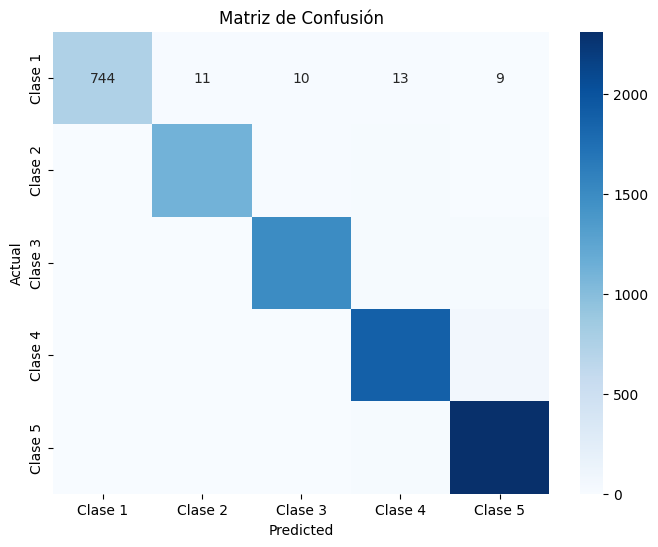

In [162]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, svmpred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4','Clase 5'], yticklabels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4','Clase 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

- Comparación de los tres modelos:

In [163]:
#comparar precision, recall y f1-score de los 3 modelos y graficarlos
precision = [precision_score(y, y_pred, average='weighted'), precision_score(y, rfpred, average='weighted'), precision_score(y, svmpred, average='weighted')]
recall = [recall_score(y, y_pred, average='weighted'), recall_score(y, rfpred, average='weighted'), recall_score(y, svmpred, average='weighted')]
f1 = [f1_score(y, y_pred, average='weighted'), f1_score(y, rfpred, average='weighted'), f1_score(y, svmpred, average='weighted')]
modelos = ['Logistic Regression', 'Random Forest', 'SVM']



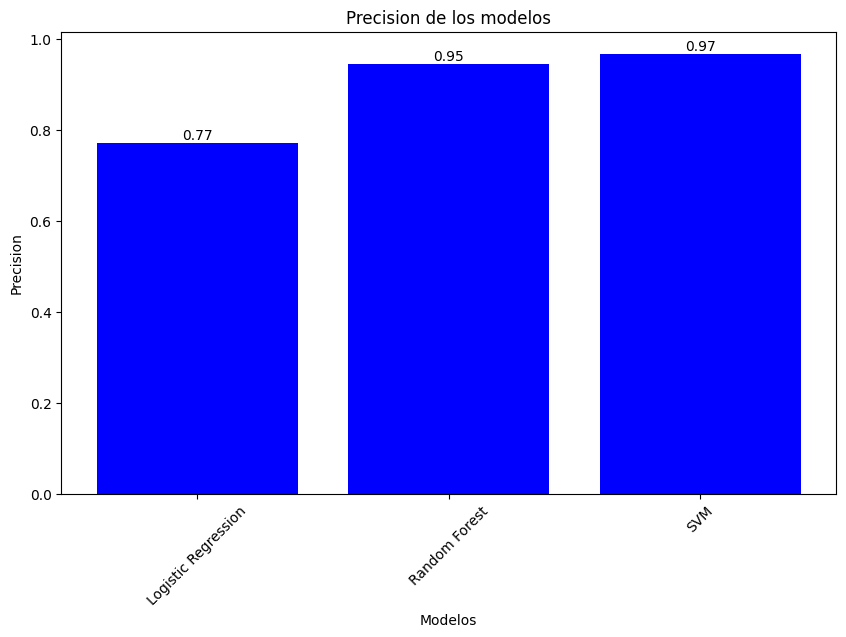

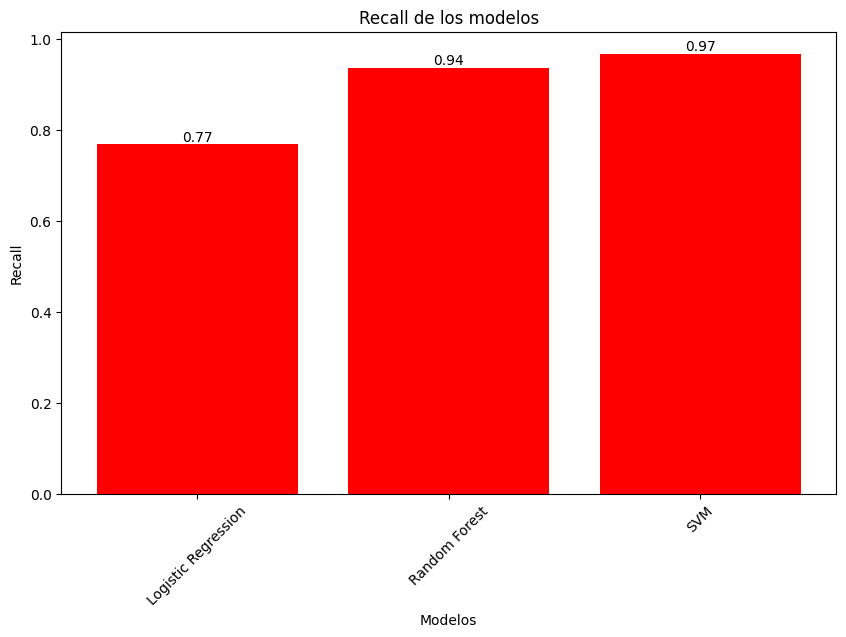

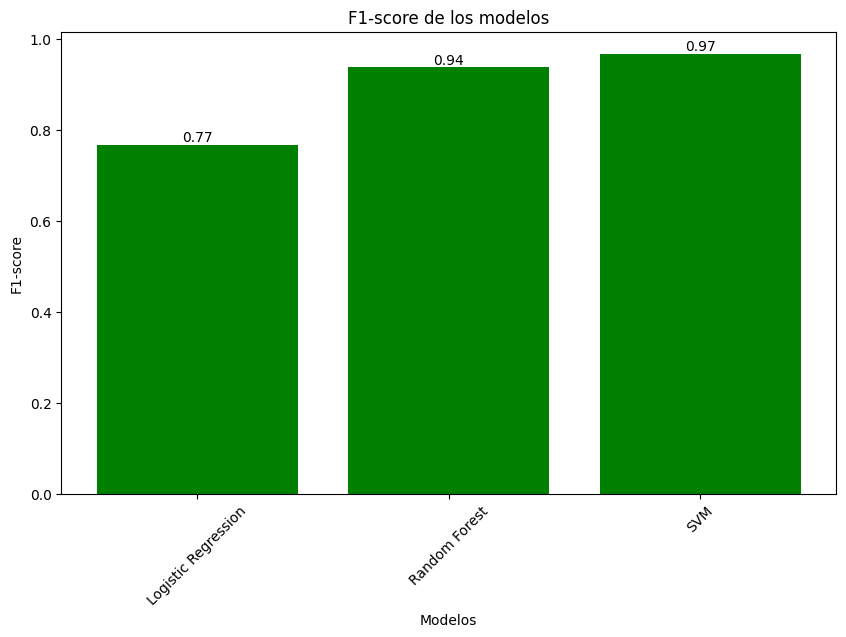

In [164]:
# Graficar la precisión
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, precision, color='b')

# Agregar los valores exactos en la parte superior de cada barra
for bar, value in zip(bars, precision):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '{:.2f}'.format(value), ha='center', va='bottom')

plt.xlabel('Modelos')
plt.ylabel('Precision')
plt.title('Precision de los modelos')
plt.xticks(rotation=45)
plt.show()

# Graficar el recall
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, recall, color='r')

# Agregar los valores exactos en la parte superior de cada barra
for bar, value in zip(bars, recall):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '{:.2f}'.format(value), ha='center', va='bottom')

plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.title('Recall de los modelos')
plt.xticks(rotation=45)
plt.show()

# Graficar el F1-score
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, f1, color='g')

# Agregar los valores exactos en la parte superior de cada barra
for bar, value in zip(bars, f1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '{:.2f}'.format(value), ha='center', va='bottom')

plt.xlabel('Modelos')
plt.ylabel('F1-score')
plt.title('F1-score de los modelos')
plt.xticks(rotation=45)
plt.show()

# 4-resultados

In [165]:
#mostrar palabras mas importantes de los modelos

#mostrar palabras de logistic regression
def mostrar_palabras_importantes_lr(Pipeline, n = 20):
    tfidf = Pipeline.named_steps['tfidf']
    clf = Pipeline.named_steps['lr']
    feature_names = np.array(tfidf.get_feature_names_out())
    sorted_coef_index = clf.coef_[0].argsort()
    print('Palabras para buenas reseñas:\n{}\n'.format(feature_names[sorted_coef_index[:n]]))
    print('Palabras para malas reseñas: \n{}'.format(feature_names[sorted_coef_index[:-n-1:-1]]))
    

mostrar_palabras_importantes_lr(pipeline)

Palabras para buenas reseñas:
['excelent' 'ubic' 'histori' 'delici' 'comod' 'agrad' 'limpi' 'ambient'
 'bonit' 'ric' 'ampli' 'camin' 'hermos' 'tom' 'espectacul' 'pued' 'piscin'
 'vist' 'ciud' 'mejor']

Palabras para malas reseñas: 
['pesim' 'suci' 'mal' 'terribl' 'horribl' 'groser' 'rob' 'pag' 'decepcion'
 'desagrad' 'cucarach' 'diner' 'cobr' 'saban' 'asquer' 'recom' 'fatal'
 'iba' 'duch' 'ped']


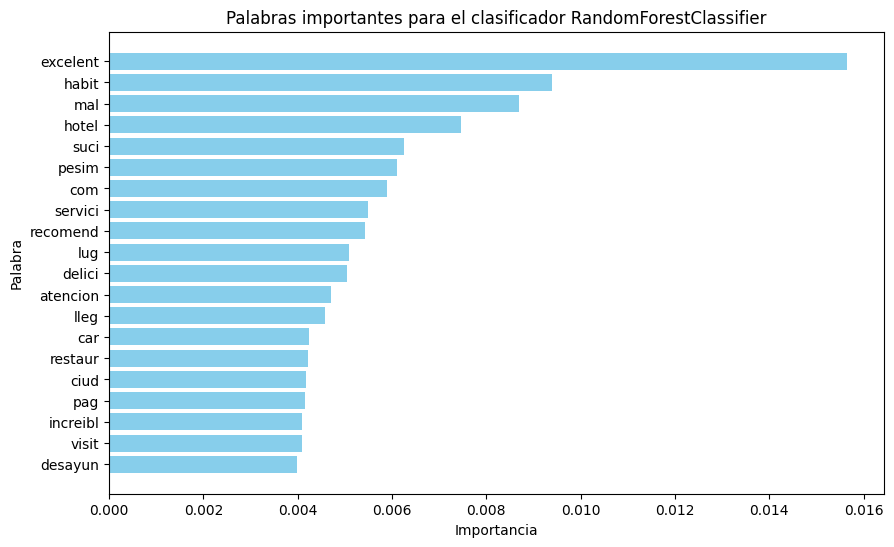

In [166]:
def mostrar_palabras_importantes_rf_grafico(pipeline):
    # Acceder al clasificador RandomForestClassifier dentro del pipeline
    clf = pipeline.named_steps['rfclf']
    # Obtener la importancia de las características
    importancia_caracteristicas = clf.feature_importances_
    # Obtener los nombres de las características del vectorizador
    nombres_caracteristicas = pipeline.named_steps['tfidf'].get_feature_names_out()
    
    # Crear un diccionario de características y su importancia
    caracteristicas_importantes = dict(zip(nombres_caracteristicas, importancia_caracteristicas))
    
    # Ordenar las características por importancia
    caracteristicas_importantes_ordenadas = sorted(caracteristicas_importantes.items(), key=lambda x: x[1], reverse=True)[:20]
    
    # Obtener los nombres de las características y su importancia
    caracteristicas = [x[0] for x in caracteristicas_importantes_ordenadas]
    importancias = [x[1] for x in caracteristicas_importantes_ordenadas]
    
    # Graficar las palabras importantes en una gráfica de barras
    plt.figure(figsize=(10, 6))
    plt.barh(caracteristicas, importancias, color='skyblue')
    plt.xlabel('Importancia')
    plt.ylabel('Palabra')
    plt.title('Palabras importantes para el clasificador RandomForestClassifier')
    plt.gca().invert_yaxis()  # Invertir el eje y para que la palabra más importante esté en la parte superior
    plt.show()

# Llamar a la función para graficar las palabras importantes
mostrar_palabras_importantes_rf_grafico(rf_pipeline)

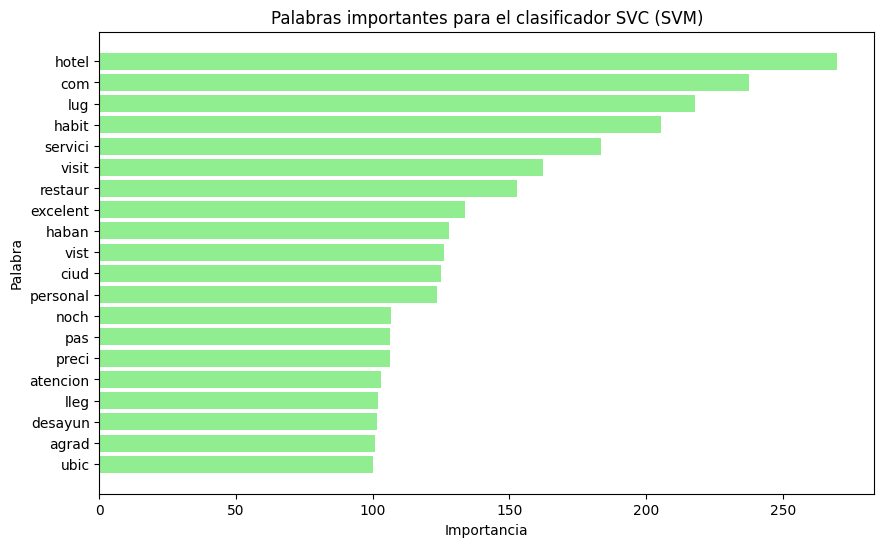

In [167]:
def mostrar_palabras_importantes_svm_grafico(pipeline):
    clf = pipeline.named_steps['svmclf']
    vectores_soporte = clf.support_vectors_
    
    nombres_caracteristicas = pipeline.named_steps['tfidf'].get_feature_names_out()
    importancia_caracteristicas = {nombre: 0 for nombre in nombres_caracteristicas}
    for vector in vectores_soporte:
        for indice, valor in zip(vector.indices, vector.data):
            importancia_caracteristicas[nombres_caracteristicas[indice]] += abs(valor)
    
    # Ordenar las características por importancia
    importancia_caracteristicas_ordenadas = sorted(importancia_caracteristicas.items(), key=lambda x: x[1], reverse=True)[:20]
    
    # Obtener los nombres de las características y su importancia
    caracteristicas = [x[0] for x in importancia_caracteristicas_ordenadas]
    importancias = [x[1] for x in importancia_caracteristicas_ordenadas]
    
    # Graficar las palabras importantes en una gráfica de barras
    plt.figure(figsize=(10, 6))
    plt.barh(caracteristicas, importancias, color='lightgreen')
    plt.xlabel('Importancia')
    plt.ylabel('Palabra')
    plt.title('Palabras importantes para el clasificador SVC (SVM)')
    plt.gca().invert_yaxis()  # Invertir el eje y para que la palabra más importante esté en la parte superior
    plt.show()

# Llamar a la función para graficar las palabras importantes
mostrar_palabras_importantes_svm_grafico(svm_pipeline)

Gracias a la aplicación de los modelos de aprendizaje, podemos identificar cuales son las características de una reseña que pueden evalular la calidad de un hotel. Estos modelos analizan una variedad de datos de los cuales podemos realizar conclusiones que pueden llegar a ser beneficiosas para el negocio.

# 5 - Evaluación en conjunto de datos

In [168]:
#aplicar el modelo de svm
y_pred_particion = svm_pipeline.predict(df_particion["Clean_Review"])
df_particion['Class'] = y_pred_particion


In [169]:
df_particion

,Review,idioma,Clean_Review,Class
0,La primera noche nos encontramos en la habitac...,es,noch encontr habit nid fiv cucarach muert alfo...,1
1,A una calle de catedral con platillos tradicio...,es,call catedral platill tradicional tip gourmet ...,4
2,Porciones muy miserables\nAgua con sabor a clo...,es,porcion miser agu sabor clor distr meser llen ...,3
3,Cartagena encanta. De todas las ciudades colon...,es,cartagen encant ciudad colonial visit lind con...,5
4,Ibamos con mucha ilusion de disfrutar el espec...,es,ibam ilusion disfrut espectacul luz son decepc...,4
...,...,...,...,...
1745,Subir en funicular y bajar en teleferico fue u...,es,sub funicul baj telefer experient vist bogot noch,5
1746,"La gente espera el lugar central en La Habana,...",es,gent esper lug central haban fiest nacional di...,3
1747,Todo excelente con el hotel: las albercas para...,es,excelent hotel alberc nin atencion meser peeer...,5
1748,Nos detuvimos en un bocado antes de la puesta ...,es,detuv boc puest sol restaur pregunt amig ped b...,2


In [170]:
#mostrar 5 registros de la particion que solo muestre review y class
df_particion[['Review','Class']].head(5)

,Review,Class
0,La primera noche nos encontramos en la habitac...,1
1,A una calle de catedral con platillos tradicio...,4
2,Porciones muy miserables\nAgua con sabor a clo...,3
3,Cartagena encanta. De todas las ciudades colon...,5
4,Ibamos con mucha ilusion de disfrutar el espec...,4


<Axes: xlabel='Class', ylabel='count'>

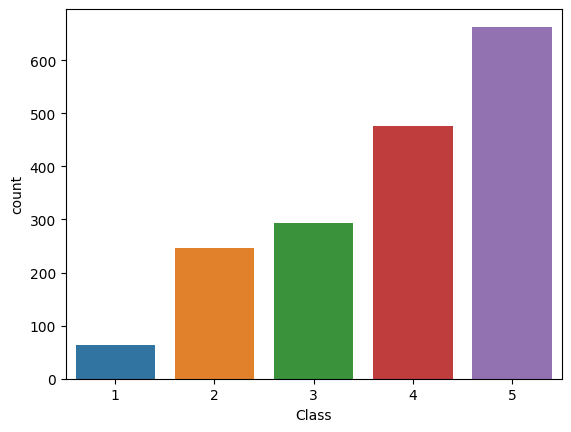

In [171]:
df_particion
sns.countplot(x = "Class", data = df_particion)

In [172]:
#exportar particion con las columans review y class
df_particion[['Review', 'Class']].to_csv('particion_prueba_estudiantes.csv', index=False, encoding='utf-8')

# 6 - Conclusiones Generales

#### Estrategias propuestas 
- Los lugares con percepción negativa es principalmente por la suciedad y la inseguridad. Por el lado de la suciedad,hay presencia de cucarachas y  las áreas de higiene como baños están en mal estado.Por el lado de la inseguridad  hay una alta tasa de robos por lo que se deben  aumentar y mejorar las medidas de seguridad actuales. 
- Los lugares con percepción negativa se ven afectados también por un mal servicio por parte de los empleados a los clientes.Hay que cambiar o re-entrenar al personal actual para mejorar el servicio. Para los lugares de buena calificación, hay que mantener el buen desempeño.
- Para los lugares con buen rating se debe mantener el aseo y mantener la calidad de los servicios ofrecidos como la calidad de la comida,piscinas,etc.
- Se debe capitalizar en las características de la ubicación. Por ejemplo, ofrecer  tures  a  lugares históricos cercanos,ubicar estratégicamente las facultades del hotel  con una buena vista(ej: la piscina con vista a la playa).

#### Justificación Utilidad de datos.
Los datos son relevantes dado que permiten hacer afirmaciones concretas sobre las características de los hoteles en base a las reseñas. Es afín a lo que desea el negocio pues se identifica que palabras influyen en una reseña  , las características positivas o negativas de un hotel según esas reseñas y en ese orden de ideas la elaboración de estrategias claras,concisas y enfocadas a un área en particular.